## Training process for ECD507 Senior Capstone Project - F1Tenth ML Based Autonomous Race Car
### Contributors - Charles Hodgins, Rishabh Hegde, Dylan DiGiacomo, and Andrew Meccariello

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import ast

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


In [2]:
class DrivingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx,1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200, 66))  # Resize using OpenCV
        image = image / 255.0  # Normalize pixel values to [0,1]
        image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        steering_angle = float(self.data.iloc[idx, 3])
        throttle = float(self.data.iloc[idx, 4])
        lidar = torch.tensor(ast.literal_eval(self.data.iloc[idx, 2]))
               
        return image, lidar, torch.tensor([steering_angle, throttle], dtype=torch.float32)


In [3]:
df = pd.read_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log3.csv")
df.columns = ["timestamp", "image_path","lidar_list","steering", "throttle", "rotational", "linear"]
df.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log3.csv", header=True, index=False)

# df0 = pd.read_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log.csv")
# df1 = pd.concat([df0, df], ignore_index=True)
# df1.columns = ["timestamp", "image_path","lidar_list","steering", "throttle", "rotational", "linear"]
# df1.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log_temp.csv", header=True, index=False)

### Check dataset size before filtering

### Filter out unusable rows from driving dataset

In [11]:
def filter_chunk(df):
    global first_chunk
    print(first_chunk)
    print(f"Initial size: {len(df)}")

    def is_valid_image(img_path):
        return os.path.exists(img_path) and cv2.imread(img_path) is not None

    
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # before_throttle = len(df)
    df = df[df["throttle"] != 0 ]
    # df = df[df['throttle'].apply(is_float)].copy()
    df = df[df["throttle"] > 0.1]
    
    # print(f"Filtered throttle: {before_throttle - len(df)} rows removed")

    # before_lidar = len(df)
    df = df[df["lidar_list"] != ""]
    df = df[pd.notna(df["lidar_list"])]
    # print(f"Filtered lidar: {before_lidar - len(df)} rows removed")

    # before_images = len(df)
    df["image_path"] = df["image_path"].str.strip()
    df = df[df["image_path"] != ""]
    df_filtered = df[df["image_path"].apply(is_valid_image)]
    # print(f"Filtered images: {before_images - len(df_filtered)} rows removed")

    # print(f"Final size: {len(df_filtered)}")
    
    print(len(df_filtered))
    
    if first_chunk:
        df_filtered.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", mode='w', index=False, header=True)
        first_chunk = False
    else:
        df_filtered.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", mode='a', index=False, header=False)


    # Save the cleaned dataset


    
first_chunk = True
index = 0
for chunk in pd.read_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log3.csv",chunksize = 10000):
    index+=1
    print(f'loaded chunk {index}')
    filter_chunk(chunk)
    # print(chunk.head())
    del chunk
    
print('done')

loaded chunk 1
True
Initial size: 10000
9082
loaded chunk 2
False
Initial size: 10000
9687
loaded chunk 3
False
Initial size: 10000
8719
loaded chunk 4
False
Initial size: 10000
9339
loaded chunk 5
False
Initial size: 10000
9135
loaded chunk 6
False
Initial size: 10000
9603
loaded chunk 7
False
Initial size: 10000
9649
loaded chunk 8
False
Initial size: 10000
9876
loaded chunk 9
False
Initial size: 10000
9465
loaded chunk 10
False
Initial size: 10000
9482
loaded chunk 11
False
Initial size: 10000
9432
loaded chunk 12
False
Initial size: 10000
8825
loaded chunk 13
False
Initial size: 10000
8695
loaded chunk 14
False
Initial size: 10000
9704
loaded chunk 15
False
Initial size: 7434
7026
done


In [3]:
import matplotlib.pyplot as plt
df = pd.read_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv")
# middle = .5192
# threshold_lower = middle -.01
# threshold_upper = middle + .01
# zero_steering = df[(df['steering'] > threshold_lower) & (df['steering'] < threshold_upper)]
# non_zero_steering = df[~((df['steering'] > threshold_lower) & (df['steering'] < threshold_upper))]

# # Randomly sample 20% of the zero-steering data to keep
# zero_sampled = zero_steering.sample(frac=.5, random_state=42)

# # Combine with the non-zero steering data
# df_balanced = pd.concat([zero_sampled, non_zero_steering], ignore_index=True)

# # Optional: Shuffle the result
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# df_balanced.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", index=False, header=False)
# print(len(df_balanced))
# plt.hist(df['steering'], bins=100)
# plt.show()

dataset = DrivingDataset('/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv')
print(len(dataset))
batch_size = 32


137719


In [3]:
# Define CNN model
batchsize=32
class CameraCNNModel(nn.Module):
    def __init__(self):
        super(CameraCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3840, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)  # Output: Steering angle and Throttle
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

import torch.nn.functional as F


class ResNet15(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,kernel_size = 7, stride = 1, padding = 'same')
        self.conv1_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv4_bn = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv6_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv6_bn = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv7_shortcut = nn.Conv2d(64,128, kernel_size = 2, stride = 2)
        self.conv7_shortcut_bn = nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv8_bn = nn.BatchNorm2d(128)

        self.conv9 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv9_bn = nn.BatchNorm2d(128)

        self.conv10 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv10_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv10_bn = nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv11_bn = nn.BatchNorm2d(256)
        self.conv11_shortcut = nn.Conv2d(128,256, kernel_size = 2, stride = 2)
        self.conv11_shortcut_bn = nn.BatchNorm2d(256)

        self.conv12 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv12_bn = nn.BatchNorm2d(256)

        self.conv13 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv13_bn = nn.BatchNorm2d(256)

        self.conv14 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv14_bn = nn.BatchNorm2d(256)

        self.FC1 = nn.Linear(256*4*12,2)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv1_maxpool(x)
        x = F.relu(self.conv1_bn(nn.MaxPool2d(kernel_size=3,stride = 2,padding = 1)(x)))

        # first block
        x1 = F.relu(self.conv2_bn(self.conv2(x)))
        x1 = F.relu(self.conv3_bn(self.conv3(x1)))
        x = x1 + x 
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x = x1 + x

        #second block
        x2 = F.relu(self.conv6_bn(self.conv6_maxpool(self.conv6(x))))
        x2 = F.relu(self.conv7_bn(self.conv7(x2)))
        # print(x2.shape)
        # print(self.conv7_shortcut_bn(self.conv7_shortcut(x)).shape)
        x = F.relu(x2 + self.conv7_shortcut_bn(self.conv7_shortcut(x)))
        x2 = F.relu(self.conv8_bn(self.conv8(x)))
        x2 = F.relu(self.conv9_bn(self.conv9(x2)))
        x = x2 + x

        x3 = F.relu(self.conv10_bn(self.conv10_maxpool(self.conv10(x))))
        x3 = F.relu(self.conv11_bn(self.conv11(x3)))
        x = F.relu(self.conv11_shortcut_bn(self.conv11_shortcut(x)))
        x3 = F.relu(self.conv12_bn(self.conv12(x3)))
        x3 = F.relu(self.conv13_bn(self.conv13(x3)))
        x3 = F.relu(self.conv14_bn(self.conv14(x3)))
        # print(x.shape)
        x = x + x3
        

        x = x.view(x.size(0),-1)
        x = self.FC1(x)
        return x
import torchvision.models as models

class ResNet18(nn.Module):
    def __init__(self, num_outputs=2):  # num_outputs is 2 for throttle and steering
        super(ResNet18, self).__init__()
        
        # Load the pre-trained ResNet-18 model
        self.resnet18 = models.resnet18()
        
        # Replace the final fully connected layer (fully connected layer has 512 input features)
        # and make it match the number of outputs (e.g., 2 for throttle and steering)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_outputs)
        
    def forward(self, x):
        # Pass the input through ResNet-18
        return self.resnet18(x)

In [4]:
# load model
dataset = DrivingDataset('/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv')

batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
model = ResNet15().to(device)

model.load_state_dict(torch.load(os.path.expanduser('~/models/testing_model.pth')))
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
print(device)

cuda


In [ ]:
# Initialize model, loss, and optimizer
import datetime
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, )
batch_size=32
print(len(dataset)/batch_size)
# Training loop
epochs = 2
print(f'Training started at: {datetime.datetime.now().strftime("%H:%M:%S")}')
for epoch in range(epochs):
    total_loss = 0
    batch = 0
    for images,_,targets in dataloader:
        images, targets = images.to(device,non_blocking=True), targets.to(device,non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch +=1
        print(f'batch {batch}',end = '\r')
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)} {datetime.datetime.now().strftime("%H:%M:%S")}')

torch.save(model.state_dict(), os.path.expanduser('~/models/testing_model.pth'))

print("Model training complete and saved as model.pth")

17214.875
Training started at: 20:23:31


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0xffffa7d94640>>
Traceback (most recent call last):
  File "/home/ecd507/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# # Save model
# torch.save(model.state_dict(), os.path.expanduser('~/models/testing_model.pth'))
# # torch.save(model.state_dict(), os.path.expanduser('~/models/4_5_2025.pth'))
# print("Model training complete and saved as model.pth")

Model training complete and saved as model.pth


41141
tensor([0.5192, 0.1983], device='cuda:0')
tensor([0.5223, 0.4523], device='cuda:0')
tensor(0.0322, device='cuda:0')


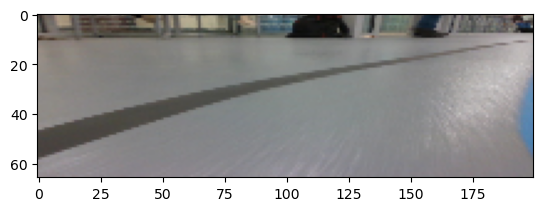

In [ ]:
# checkpoint = torch.load(os.path.expanduser('~/models/3_28_2025_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
model = ResNet15().to(device)
model.load_state_dict(checkpoint)
model.eval()
criterion = nn.MSELoss()
idx = int(np.random.rand()*len(dataset))
print(idx)
img,lidar, label = dataset[idx]
img = img.to(device)
label = label.to(device)
img = img.unsqueeze(0) 
img_ = img.to('cpu')
img_ = np.squeeze(img_)
img_ = np.transpose(img_, (1,2,0))  # Change shape to (C, H, W)
img_ = np.array(img_)

# img_ = cv2.cvtColor(np.array(img_), cv2.COLOR_RGB2HSV)

# print(img_.shape)

with torch.no_grad():
    output = model(img)
plt.imshow(img_)

print(label)
print(output[0])
loss = criterion(output[0],label)
print(loss)


In [ ]:
# import datetime
# now = datetime.datetime.now()
# formatted = now.strftime("%Y-%m-%d_%H:%M:%S %Z")  
# formatted = formatted + '_log'

# print(formatted)
# with open(f'{datetime.datetime.now().date()}{datetime.datetime.now().time()}log.txt') as f:
#     print('Poop')
